In [1]:
# we load the things!

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
from ngsolve.fem import LeviCivitaSymbol, Einsum

import scipy.sparse as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



Some operators on coefficient functions to easen the load of compute hodge laplacians of manufactured solutions..

In [2]:
coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[0].Diff(y) - cf[1].Diff(x))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

## Convergence study for Hodge Laplace in 2D for 1-forms
- From the first implementation that ran!
- With sinusoidal manufactured solution that vanishes on the boundary

In [50]:
def hodgeLaplace2Dfor1forms(mesh,
                            omega_m = CF((0,0)),
                            order = 1,
                            C_w = 1 ):

    h_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl)
    h_1 = H1(mesh, order=order)     # For 0-forms, H1 space
    fes = h_curl * h_1
    (omega, sigma), (eta, tau) = fes.TnT()

    a = BilinearForm(fes)

    a += sigma * tau * dx
    a += - omega * grad(tau) * dx

    a +=  grad(sigma) * eta * dx
    a +=  curl(omega) * curl(eta) * dx

    n = specialcf.normal(mesh.dim)
    t = t = CF((n[1], -n[0]))
    

    a += -curl(omega) * eta.Trace()*t  * ds(skeleton = True, definedon=mesh.Boundaries(".*"))
    a += omega.Trace() * t*curl(eta) *  ds(skeleton=True, definedon=mesh.Boundaries(".*"))

    h = specialcf.mesh_size #computed on every edge of the boundary integration is way faster than setting a constant
    a += (C_w / h) * omega.Trace()*t * eta.Trace()*t * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    
    # Hodge Laplcae of Omega Manufactured
    # hL_omega_m = CF(GCurl(GCurl(omega_m)) - GGrad(GDiv(omega_m))) 
    # f_rhs = LinearForm(fes)
    # f_rhs += hL_omega_m * eta * dx

    div_omega = CF(omega_m[0].Diff(x) + omega_m[1].Diff(y)) # take this *(-1) and you one has sigma manufactured!
    grad_div_omega = CF((div_omega.Diff(x), div_omega.Diff(y)))

    rot_omega = CF(omega_m[1].Diff(x) - omega_m[0].Diff(y))
    curl_rot_omega = CF((rot_omega.Diff(y), - rot_omega.Diff(x)))

    grad_sigma_manufactured = CF((-div_omega.Diff(x), -div_omega.Diff(y)))

    hL_omega_m = CF(curl_rot_omega - grad_div_omega)
    f_rhs = LinearForm(fes)
    f_rhs += hL_omega_m * eta * dx

    a.Assemble()
    f_rhs.Assemble()

    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    #cond_nr = np.linalg.cond(A.todense()) # takes way longer than solving the system lolll..

    sol = GridFunction(fes)
    res = f_rhs.vec-a.mat * sol.vec
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    sol.vec.data += inv * res

    gf_omega , gf_sigma = sol.components

    # curl_omega = curl(gf_omega)
    # grad_sigma = grad(gf_sigma)

    # L2_error_omega = sqrt(Integrate((gf_omega - omega_m)**2, mesh))
    # L2_error_curl_omega = sqrt(Integrate((curl_omega - GCurl(omega_m))**2, mesh))
    # L2_error_sigma = sqrt(Integrate((gf_sigma + GDiv(omega_m))**2, mesh))
    # L2_error_grad_sigma = sqrt(Integrate((grad_sigma - GGrad(GDiv(omega_m)))**2, mesh))

    curl_omega = curl(gf_omega)
    div_omega_m = GDiv(omega_m)
    grad_sigma = grad(gf_sigma)

    L2_error_omega = sqrt(Integrate((gf_omega - omega_m)**2, mesh))
    L2_error_curl_omega = sqrt(Integrate((curl_omega - rot_omega)**2, mesh))
    L2_error_sigma = sqrt(Integrate((gf_sigma + div_omega_m)**2, mesh))
    L2_error_grad_sigma = sqrt(Integrate((grad_sigma - grad_sigma_manufactured)**2, mesh))

    # print("Residual: ", Norm(res))
    # print("L2 Error omega:", sqrt(Integrate((gf_omega - omega_exact)**2, mesh)))
    # print("L2 Error curl(omega)", sqrt(Integrate((curl_omega - rot_omega)**2, mesh)))
    # print("L2 Error sigma:", sqrt(Integrate((gf_sigma + div_omega)**2, mesh)))
    # print("L2 Error grad(sigma):", sqrt(Integrate((grad_sigma - grad_sigma_manufactured)**2, mesh)))

    return fes.ndof, Norm(res), L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma

In [51]:
def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [52]:
Cw_vals = logspace_custom_decades(10, 10**7, 5)
order_cw = 3
hmax_cw = 0.025
results_cw = []

for C_w in Cw_vals:

    mesh = Mesh(unit_square.GenerateMesh(maxh=hmax_cw))
    omega_m = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y)))
    
    ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace2Dfor1forms(mesh, omega_m, order=order_cw, C_w=C_w)
    
    #print("solving with C_w = ", C_w)
    results_cw.append({
        'order': order_cw,
        'hmax': hmax_cw,
        'C_w': C_w,
        'ndof': ndof,
        'res': res,
        'L2_error_omega': L2_error_omega,
        'L2_error_curl_omega': L2_error_curl_omega,
        'L2_error_sigma': L2_error_sigma,
        'L2_error_grad_sigma': L2_error_grad_sigma
    })

df_cw = pd.DataFrame(results_cw)



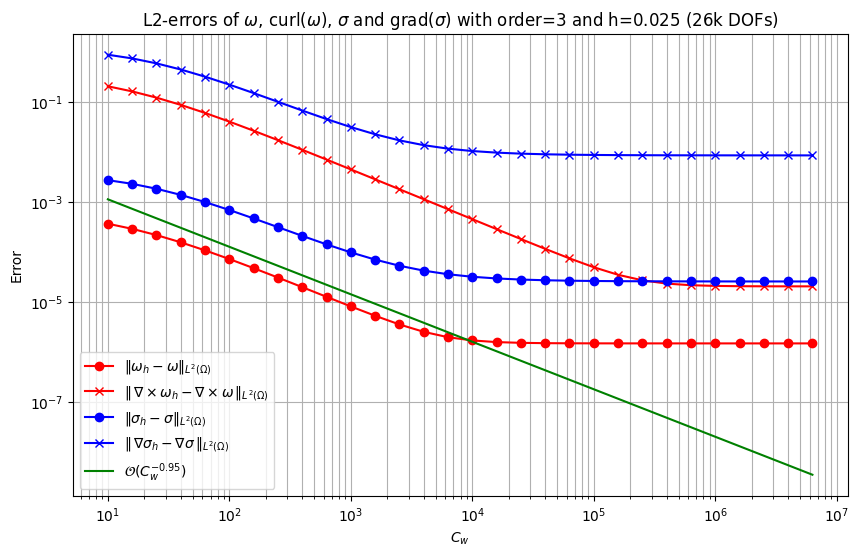

6309573.44480193


In [53]:
plt.figure(figsize=(10, 6))

#  'L2_error_omega' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_omega'], label='L2_error_omega', marker='o', color='red')

#  'L2_error_curl_omega' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_curl_omega'], label='L2_error_curl_omega', marker='x', color='red')

#  'L2_error_sigma' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_sigma'], label='L2_error_sigma', marker='o', color='blue')

#  'L2_error_grad_sigma' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_grad_sigma'], label='L2_error_grad_sigma', marker='x', color='blue')

C_w_ref = np.array(df_cw['C_w'])
reference_line = 0.01*(C_w_ref ** -0.95) # O(C_w^{-0.95})
plt.plot(C_w_ref, reference_line, label='$O(C_w^{-0.95})$', linestyle='-', color='green')


plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='both', linestyle='-')

plt.xlabel('$C_w$')
plt.ylabel('Error')
plt.title('L2-errors of $\omega$, curl($\omega$), $\sigma$ and grad($\sigma$) with order=3 and h=0.025 (26k DOFs)')


plt.legend([r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
            r'$\Vert \, \nabla \times \omega_h - \nabla \times \omega \, \Vert_{L^2(\Omega)}$',
            r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
            r'$\Vert \, \nabla \sigma_h - \nabla  \sigma \, \Vert_{L^2(\Omega)}$',
            r'$\mathcal{O}(C_w^{-0.95})$']
            )

plt.show()

min_index = df_cw['L2_error_grad_sigma'].idxmin()
min_C_w = df_cw['C_w'][min_index]
print(min_C_w)

Data Generation for plots!

In [130]:
Cw_vals = min_C_w
#Cw_vals = 10**3

order = np.linspace(1,5,5)
maxh = [0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

results = []
for hmax in maxh:
    for order_mesh in order:
        ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace2Dfor1forms(order=order_mesh, maxh=hmax, C_w=Cw_vals)
        
        #print("Currently solving with h = ", hmax, " and mesh order ", order_mesh)
        results.append({
            'order': order_mesh,
            'hmax': hmax,
            'C_w': Cw_vals,
            'ndof': ndof,
            'res': res,
            'L2_error_omega': L2_error_omega,
            'L2_error_curl_omega': L2_error_curl_omega,
            'L2_error_sigma': L2_error_sigma,
            'L2_error_grad_sigma': L2_error_grad_sigma
        })

df = pd.DataFrame(results)

In [ ]:

error_columns = ['L2_error_omega', 'L2_error_curl_omega', 'L2_error_sigma', 'L2_error_grad_sigma']


for error_col in error_columns:
    plt.figure(figsize=(10, 6)) 

    for order_mesh, group in df.groupby('order'):
        plt.plot(group['hmax'], group[error_col], label=f'Order {int(order_mesh)}', marker='o')

    # Adding Big-O reference lines for h_max^-1, h_max^-2, and h_max^-3
    h_ref = np.array(sorted(df['hmax'].unique()))  # Get unique sorted h_max values for reference lines
    plt.plot(h_ref, h_ref**1, label=r'$O(h_{max})$', linestyle='--', color='black')
    plt.plot(h_ref, h_ref**2, label=r'$O(h_{max}^{2})$', linestyle='--', color='red')
    #plt.plot(h_ref, h_ref**3, label=r'$O(h_{max}^{3})$', linestyle='--', color='blue')

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('$h_{max}$')
    plt.ylabel(r'$L^2$ - Error')
    plt.title(f'{error_col}')
    plt.grid(True, which='both', linestyle='--')

    plt.legend(title="Order and Big-O")

    plt.show()